# Actor–Critic

- **Actor (política)**: modelo que produce una distribución de probabilidad sobre acciones `π(a|s)`.
- **Critic (valor)**: modelo que estima el valor del estado `V(s)` para reducir la varianza del gradiente.
- **Ventaja (advantage)**: `A(s,a) = G_t - V(s_t)`, mide qué tan buena fue la acción comparada con lo esperado.
- **Retorno (return)**: suma de recompensas que usamos como objetivo del Critic.

## Integrantes
- Diego Leiva - 21752
- Pablo Orellana - 21790

## Librerias

In [1]:
import math
import random

import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import matplotlib.pyplot as plt 
from IPython.display import clear_output

import platform

## Entorno CartPole Gymnasium

In [2]:
env_name = "CartPole-v1"
env = gym.make(env_name)

## Configuración de PyTorch

In [3]:
# Semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Actor-Critic

## Arquitectura `ActorCritic`

- **Crítico (`self.critic`)**: estima `V(s)` (valor del estado). Se usa para **bootstrapping** y para calcular la **ventaja**.
- **Actor (`self.actor`)**: produce **logits** o **probabilidades** sobre las acciones. Con los logits usamos `Categorical(logits=...)` para mayor estabilidad numérica, y dejamos que la distribución aplique la softmax internamente.        

In [4]:
class CriticMLP(nn.Module):
    """ 
    Modelo de Red neuronal del laboratorio pasado, 
    para cumplir el rol de Critic en Actor-Critic. 
    """
    def __init__(self, in_dim: int = 4, hidden: list = [128, 128]):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, 1)]  # salida escalar V(s)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Mantener dtype/device coherente con ActorCritic
        if not isinstance(x, torch.Tensor):
            x = torch.as_tensor(x, dtype=torch.float32)
        return self.net(x).squeeze(-1)  # (B,) o escalar

In [5]:
# Clase ActorCritic: separa Actor (política) y Critic (valor).
class ActorCritic(nn.Module): 
    def __init__(self, n_inputs, n_outputs, hidden_size, std = 0.0): 
        super(ActorCritic, self).__init__() 

        # Usar el modelo del Critic basado en el MLP 
        # del laboratorio pasado
        self.critic = CriticMLP(
            in_dim=n_inputs, 
            hidden=[hidden_size, hidden_size]
            )

        self.actor = nn.Sequential(
            nn.Linear(n_inputs,hidden_size), nn.ReLU() 
            , nn.Linear(hidden_size,hidden_size), nn.ReLU()
            , nn.Linear(hidden_size, n_outputs)
        )
    
    def forward(self, x): 
        logits = self.actor(x)
        dist = Categorical(logits=logits)
        value = self.critic(x)
        return dist, value


## Función `compute_returns`

Calcula los **retornos** (targets para el crítico) con **bootstrap** usando `V(s_{t+1})`.  
Usualmente:

$$
G_t = r_t + \gamma \cdot \text{mask}_t \cdot G_{t+1}
$$

donde `mask_t = 0` al terminar el episodio para **cortar** la propagación del retorno.

## Muestreo de acciones desde la política

`dist.sample()` obtiene una acción estocástica según `π(a|s)`.  
Esta estocasticidad fomenta la **exploración**. En evaluación, podrías usar `dist.probs.argmax()` para una política **greedy**.

**Nota:** para entornos discretos, convierte la acción a `int` antes de `env.step(...)`.

In [6]:
class ObsNorm:
    def __init__(self, eps=1e-8):
        self.count = 0
        self.mean = None
        self.var  = None
        self.eps  = eps

    def update(self, x):
        # Asegurarse de que es torch.Tensor
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.flatten()

        if self.mean is None:
            self.mean = x.clone()
            self.var  = torch.ones_like(x)
            self.count = 1
            return

        self.count += 1
        delta = x - self.mean
        self.mean += delta / self.count
        self.var  += delta * (x - self.mean)

    def normalize(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.flatten()
        std = torch.sqrt(self.var / max(self.count-1, 1) + self.eps)
        return (x - self.mean) / std    # <- devuelve tensor


obs_norm = ObsNorm()

In [7]:
# dist.sample(): muestrea acciones para explorar.
# En evaluación, usar la acción más probable si se desea comportamiento determinista.
# compute_returns: implementa el bootstrapping con V(s_{t+1}) y máscaras.
def compute_returns_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95):
    """
    rewards, masks, values: tensores 1D de longitud T
    next_value: escalar 1D (valor del estado posterior al último paso)
    Devuelve: returns (T), advantages (T)
    """
    T = len(rewards)
    returns = torch.zeros(T, dtype=torch.float32)
    adv = torch.zeros(T, dtype=torch.float32)

    gae = 0.0
    for t in reversed(range(T)):
        v_next = next_value if t == T-1 else values[t+1]
        delta = rewards[t] + gamma * v_next * masks[t] - values[t]
        gae = delta + gamma * lam * masks[t] * gae
        adv[t] = gae
        returns[t] = adv[t] + values[t]
    return returns, adv

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [8]:
def test_env(vis=False, model = None):
    state, _  = env.reset()
    # state = obs_norm.normalize(state)
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        dist, _ = model(state)
        next_state, reward, terminated, truncated, _ = env.step(int(dist.probs.argmax(dim = -1)))
        # next_state = obs_norm.normalize(next_state)  
        done = np.logical_or(terminated, truncated)
        state = next_state
        total_reward += reward
    
    return total_reward

In [14]:
# Exponencial Moving Average para suavizar (opcional)
def ema(x, alpha=0.1):
    if len(x) == 0:
        return []
    y = [x[0]]
    for t in range(1, len(x)):
        y.append(alpha * x[t] + (1 - alpha) * y[-1])
    return y

def plot_losses(frames_hist, actor_hist, critic_hist, total_hist, use_ema=True):
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    if use_ema:
        plt.plot(frames_hist, ema(actor_hist), label='Actor loss (EMA)')
        plt.plot(frames_hist, ema(critic_hist), label='Critic loss (EMA)')
        plt.plot(frames_hist, ema(total_hist), label='Total loss (EMA)')
    else:
        plt.plot(frames_hist, actor_hist, label='Actor loss')
        plt.plot(frames_hist, critic_hist, label='Critic loss')
        plt.plot(frames_hist, total_hist, label='Total loss')
    plt.xlabel('Frames')
    plt.ylabel('Loss')
    plt.title('NEW Evolución de pérdidas: Actor / Critic / Total')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n 
hidden_size = 128

In [11]:
print(f"{n_inputs} - {n_outputs} - {hidden_size}")

4 - 2 - 128


## Muestreo de acciones desde la política

`dist.sample()` obtiene una acción estocástica según `π(a|s)`.  
Esta estocasticidad fomenta la **exploración**. En evaluación, podrían usar `dist.probs.argmax()` para una política **greedy**.

## Ventaja (Advantage)

La **ventaja** mide cuánto mejor/peor fue la acción respecto a lo esperado por el crítico:
$$
A_t = G_t - V(s_t)
$$

**Consejo práctico:**
- Normaliza `A_t` para estabilizar el entrenamiento:

```python
advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
```

## Pérdidas del Actor y del Crítico

- **Actor:** maximiza la probabilidad de acciones con `A_t > 0` y minimiza con `A_t < 0`:
$$ 
L_{actor} = -\mathbb{E}[\log \pi(a_t|s_t) \cdot A_t] 
$$

  Usamos `advantage.detach()` para **no** retropropagar a través del crítico.

- **Crítico:** se entrena con MSE hacia los retornos:
$$ 
L_{critic} = \mathbb{E}[(G_t - V(s_t))^2] 
$$

- **Total:** `loss = L_actor + c_v * L_critic ( - β * H )` donde `H` es entropía (opcional) para promover exploración.

## Paso de Optimización

Secuencia típica en PyTorch:
1. `optimizer.zero_grad()` para limpiar gradientes acumulados.
2. `loss.backward()` para calcular gradientes vía backprop.
3. `optimizer.step()` para actualizar parámetros.

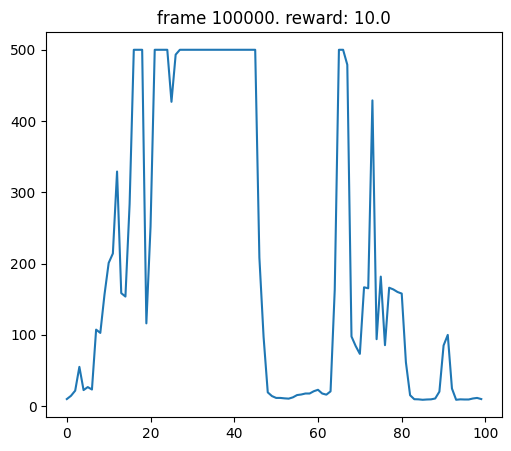

In [12]:
actor_critic_model = ActorCritic(n_inputs, n_outputs, hidden_size)
optimizer = optim.Adam(actor_critic_model.parameters(), lr = 3e-4)

n_steps = 50
max_frames = 100000

state, _ = env.reset()
obs_norm.update(state)
state = obs_norm.normalize(state)

test_rewards = []
frame_idx = 0

frames_hist  = []
actor_hist   = []
critic_hist  = []
total_hist   = []

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0.0

    for _ in range(n_steps):

        state_t = torch.as_tensor(state, dtype=torch.float32)
        dist, value = actor_critic_model(state_t)

        action = dist.sample()
        action_np = int(action.item())

        next_state, reward, terminated, truncated, _ = env.step(action_np)
        
        next_state = obs_norm.normalize(next_state)
        done = np.logical_or(terminated, truncated)

        if done: 
            state, _  = env.reset() 
            state_t = torch.as_tensor(state, dtype=torch.float32)

        log_prob = dist.log_prob(action)
        if log_prob.ndim > 1:
            log_prob = log_prob.sum(-1)
        entropy = entropy + dist.entropy().mean() 

        log_probs.append(log_prob)
        values.append(value.squeeze(-1))
        rewards.append(torch.as_tensor(reward, dtype=torch.float32))
        masks.append(torch.as_tensor(1.0 - done.astype(np.float32), dtype=torch.float32))  # (n_envs,)
        

        state = next_state
        if done: 
            state, _  = env.reset()

        obs_norm.update(state)
        state = obs_norm.normalize(state) 

        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env(model = actor_critic_model) for _ in range(5)]))
            plot(frame_idx, test_rewards)  # tu función existente

    next_state_t = torch.as_tensor(next_state, dtype=torch.float32)
    obs_norm.update(next_state_t)
    next_state_t = obs_norm.normalize(next_state_t)

    with torch.no_grad():
        _, next_value = actor_critic_model(next_state_t)

    next_value = next_value.squeeze(-1).unsqueeze(-1)

    returns, advantages = compute_returns_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95)


    log_probs = torch.stack(log_probs)   # [T]
    values    = torch.stack(values)      # [T]
    adv_norm = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    actor_loss  = -(log_probs * adv_norm.detach()).mean()
    critic_loss = (returns - values).pow(2).mean()            # <- sin normalizar
    # critic_loss = F.smooth_l1_loss(values, returns)
    loss = actor_loss + 0.5 * critic_loss - 0.05 * (entropy / len(log_probs))
    

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(actor_critic_model.parameters(), 0.5)
    optimizer.step()

    # --- NUEVO: registrar y graficar ---
    frames_hist.append(frame_idx)
    actor_hist.append(actor_loss.item())
    critic_hist.append(critic_loss.item())
    total_hist.append(loss.item())

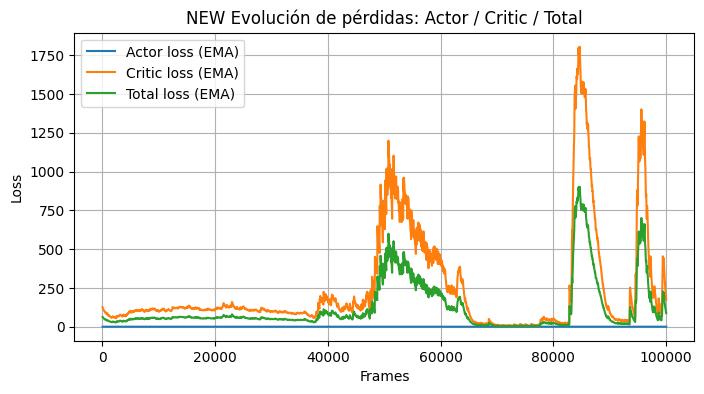

In [15]:
plot_losses(frames_hist, actor_hist, critic_hist, total_hist, use_ema=True)